Importing the dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

Importing the dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/akash/CODE/Potato_Disease_Predictor/DATASET",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True,
    )

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 2 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1]


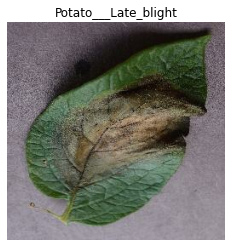

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

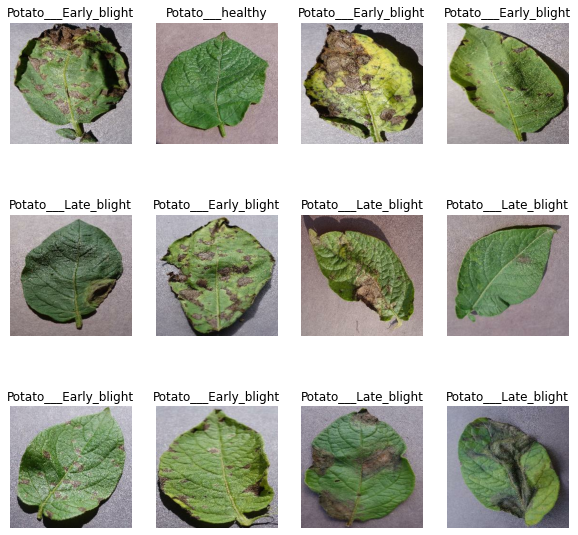

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

80% == training
10% == validation
10% == test

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split = 0.8 , val_split=0.1,test_split =0.1,shuffle = True,shufflesize=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shufflesize, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    #test_ds = ds.skip(val_size).take(test_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(test_ds)

8

In [20]:
len(val_ds)

6

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#read image from disk next time when we need that image it will keep the image
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Data reshaping and augmentation

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Building the Convolutional Neural Network

In [24]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [25]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

Training and testing the model

In [27]:
history = model.fit(
train_ds,
epochs=EPOCHS,
verbose=1,
validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 92s 2s/step - loss: 0.9200 - accuracy: 0.4751 - val_loss: 0.8247 - val_accuracy: 0.5625
Epoch 2/10
54/54 [==============================] - 84s 2s/step - loss: 0.7423 - accuracy: 0.6157 - val_loss: 0.6233 - val_accuracy: 0.6719
Epoch 3/10
54/54 [==============================] - 75s 1s/step - loss: 0.5066 - accuracy: 0.7737 - val_loss: 0.3418 - val_accuracy: 0.8438
Epoch 4/10
54/54 [==============================] - 79s 1s/step - loss: 0.3227 - accuracy: 0.8767 - val_loss: 0.2342 - val_accuracy: 0.9062
Epoch 5/10
54/54 [==============================] - 80s 1s/step - loss: 0.3289 - accuracy: 0.8652 - val_loss: 0.2102 - val_accuracy: 0.9271
Epoch 6/10
54/54 [==============================] - 80s 1s/step - loss: 0.2312 - accuracy: 0.9062 - val_loss: 0.2090 - val_accuracy: 0.9115
Epoch 7/10
54/54 [==============================] - 81s 1s/step - loss: 0.1963 - accuracy: 0.9236 - val_loss: 0.1105 - val_accuracy: 0.9635
Epoch 8/10
54/54 [==

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 387ms/step - loss: 0.1185 - accuracy: 0.9414


In [29]:
scores

[0.11852353066205978, 0.94140625]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [32]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.47511574625968933,
 0.6157407164573669,
 0.7737268805503845,
 0.8767361044883728,
 0.8651620149612427,
 0.90625,
 0.9236111044883728,
 0.9288194179534912,
 0.9444444179534912,
 0.9282407164573669]

In [34]:
len(history.history['accuracy'])

10

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Data visualisation

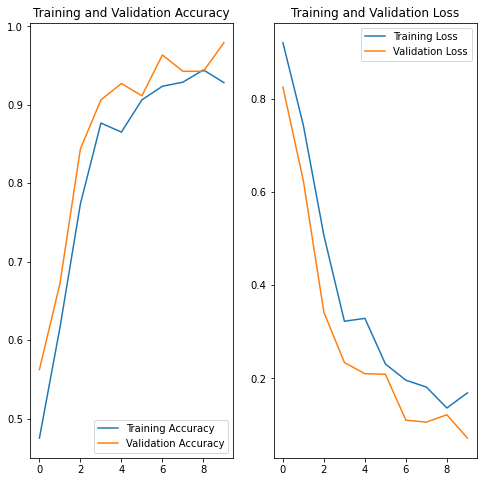

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Making a Predictive System

First image to predict : 
First image's actual label :  Potato___Early_blight
Predicted label :  Potato___Early_blight


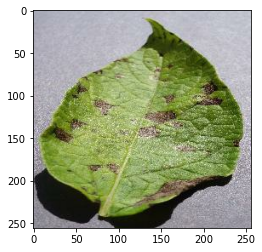

In [38]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("First image to predict : ")
    plt.imshow(first_image)
    print("First image's actual label : ",class_names[first_label])
    
    batch_prediction=model.predict(image_batch)
    print("Predicted label : ", class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

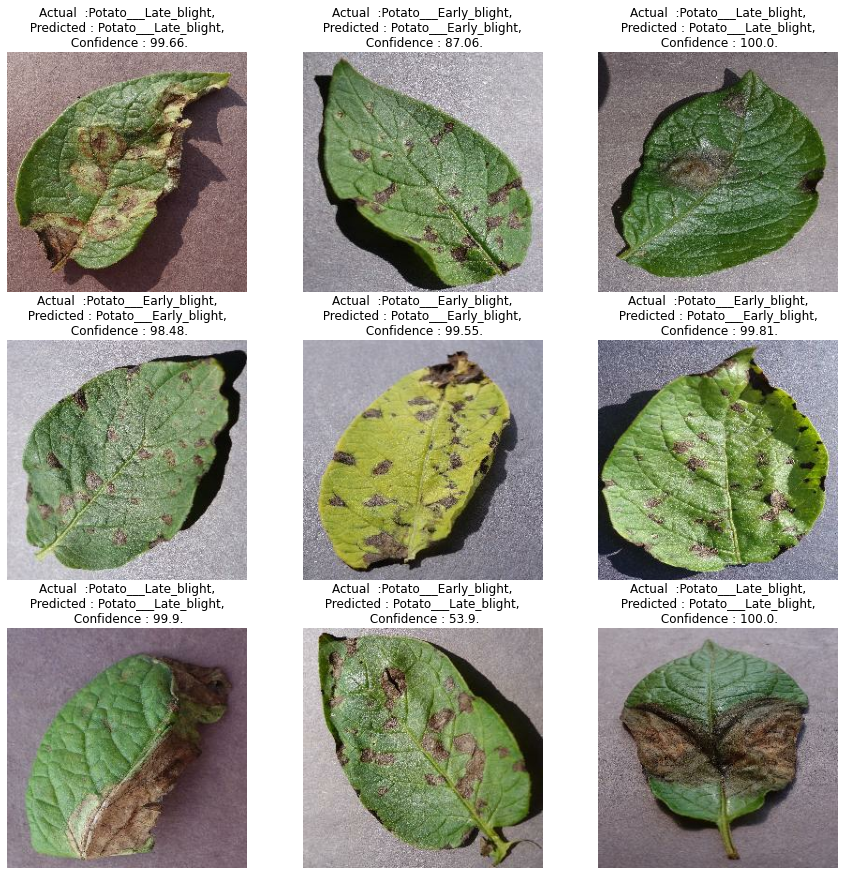

In [40]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual  :{actual_class},\n Predicted : {predicted_class}, \n Confidence : {confidence}.")
        plt.axis('off')
        

Saving the model

In [42]:
import os

In [43]:
os.listdir("../models")

['1', '2', '3']

In [44]:
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1

In [45]:
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets
